# Forest: Tree crown detection

## Context
### Purpose
Detect tree crown using state-of-art models

### Modelling approach
A prebuilt Deep Learning model, named _DeepForest_, is used to predict individual tree crowns from an airborne RGB image.

### Highlights
* _DeepForest_ was trained on data from the National Ecological Observatory Network.

### Authors
Alejandro Coca-Castro, The Alan Turing Institute, [@acocac](https://github.com/acocac)

:::{note}
The author acknowledges [DeepForest](https://deepforest.readthedocs.io/en/latest/) contributors. Some code snippets were extracted from DeepForest [GitHub public repository](https://github.com/weecology/DeepForest).
:::

## Install and load libraries

In [29]:
!pip -q install git+https://github.com/ESM-VFC/intake_zenodo_fetcher.git ##Intake Zenodo Fetcher
!pip -q install DeepForest

In [1]:
import glob
import os
import urllib

import intake
from intake_zenodo_fetcher import download_zenodo_files_for_entry
import matplotlib.pyplot as plt
import xmltodict
import cv2

import tempfile

%matplotlib inline

## Fetch a RGB image from Zenodo

In [2]:
# create a temp dir
path = tempfile.mkdtemp()

catalog_file = os.path.join(path, 'catalog.yaml')

with open(catalog_file, 'w') as f:
    f.write('''
sources:
  NEONTREE_rgb:
    driver: xarray_image
    description: 'NeonTreeEvaluation RGB images (collection)'
    metadata:
      zenodo_doi: "10.5281/zenodo.3459803"
    args:
      urlpath: "{{ CATALOG_DIR }}/NEONsample_RGB/2018_MLBS_3_541000_4140000_image_crop.tif"
      ''')

In [3]:
cat_tc = intake.open_catalog(catalog_file)

In [4]:
for catalog_entry in list(cat_tc):
    download_zenodo_files_for_entry(
        cat_tc[catalog_entry],
        force_download=False
    )

will download https://zenodo.org/api/files/5b372ed9-e4ec-41b0-a652-f0ce7d760e60/2018_MLBS_3_541000_4140000_image_crop.tif to /var/folders/l8/99_59fvn4bl2szm125grkgqw0000gr/T/tmpr51mlgne/NEONsample_RGB/2018_MLBS_3_541000_4140000_image_crop.tif


  0%|          | 0.00/100 [00:00<?, ?B/s]

In [5]:
tc_rgb = cat_tc["NEONTREE_rgb"].to_dask()

/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/intake_xarray/image.py:337: FutureWarning: open_files is deprecated and will be removed in a future release. Please use fsspec.core.open_files instead.
  files = open_files(self.urlpath, **self.storage_options)
/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/xarray/core/dataset.py:2145: FutureWarning: None value for 'chunks' is deprecated. It will raise an error in the future. Use instead '{}'
  warnings.warn(


In [6]:
tc_rgb

<xarray.DataArray (y: 1864, x: 1429, channel: 3)>
dask.array<xarray-<this-array>, shape=(1864, 1429, 3), dtype=uint8, chunksize=(1864, 1429, 3), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 ... 1857 1858 1859 1860 1861 1862 1863
  * x        (x) int64 0 1 2 3 4 5 6 7 ... 1422 1423 1424 1425 1426 1427 1428
  * channel  (channel) int64 0 1 2

## Load and prepare labels

In [8]:
filenames = glob.glob(os.path.join(path, './NEONsample_RGB/*.tif'))
filesn = [os.path.basename(i) for i in filenames]

In [10]:
##Create ordered dictionary of .xml annotation files
def loadxml(imagename):
  imagename = imagename.replace('.tif','')
  fullurl = "https://raw.githubusercontent.com/weecology/NeonTreeEvaluation/master/annotations/" + imagename + ".xml"
  file = urllib.request.urlopen(fullurl)
  data = file.read()
  file.close()
  data = xmltodict.parse(data)
  return data

allxml = [loadxml(i) for i in filesn]

In [11]:
# function to extract bounding boxes
def extractbb(i):
  bb = [f['bndbox'] for f in allxml[i]['annotation']['object']]
  return bb

bball = [extractbb(i) for i in range(0,len(allxml))]
print(len(bball))

1


## Visualise image and labels

In [12]:
# function to plot images
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

In [13]:
image = tc_rgb

In [14]:
# plot predicted bbox
image2 = image.values.copy()
target_bbox = bball[0]
print(target_bbox)

[OrderedDict([('xmin', '1377'), ('ymin', '697'), ('xmax', '1429'), ('ymax', '752')]), OrderedDict([('xmin', '787'), ('ymin', '232'), ('xmax', '811'), ('ymax', '256')]), OrderedDict([('xmin', '490'), ('ymin', '168'), ('xmax', '516'), ('ymax', '191')]), OrderedDict([('xmin', '210'), ('ymin', '82'), ('xmax', '237'), ('ymax', '111')]), OrderedDict([('xmin', '174'), ('ymin', '209'), ('xmax', '209'), ('ymax', '250')]), OrderedDict([('xmin', '8'), ('ymin', '293'), ('xmax', '76'), ('ymax', '357')]), OrderedDict([('xmin', '1283'), ('ymin', '377'), ('xmax', '1336'), ('ymax', '417')]), OrderedDict([('xmin', '774'), ('ymin', '111'), ('xmax', '809'), ('ymax', '152')]), OrderedDict([('xmin', '980'), ('ymin', '548'), ('xmax', '1032'), ('ymax', '604')]), OrderedDict([('xmin', '283'), ('ymin', '229'), ('xmax', '311'), ('ymax', '257')]), OrderedDict([('xmin', '1360'), ('ymin', '1647'), ('xmax', '1392'), ('ymax', '1678')]), OrderedDict([('xmin', '253'), ('ymin', '1317'), ('xmax', '277'), ('ymax', '1349')

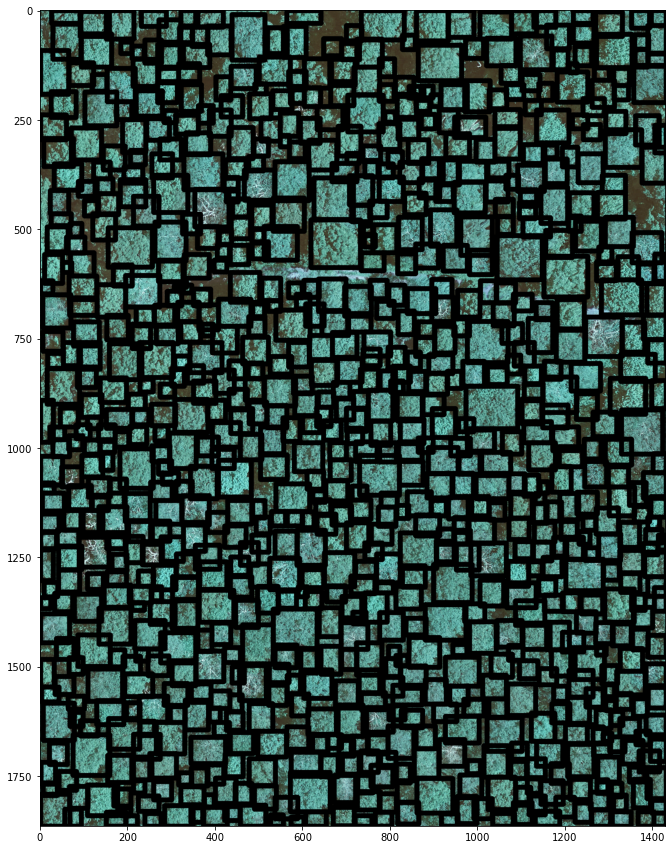

In [15]:
for row in target_bbox:
    cv2.rectangle(image2, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
cv2_imshow(image2)
plt.show()

## Load *DeepForest* pretrained model

In [16]:
from deepforest import main

In [17]:
# load deep forest model
model = main.deepforest()
model.use_release()

Reading config file: /Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/deepforest/data/deepforest_config.yml
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [18]:
pred_boxes = model.predict_image(image=image.values)
print(pred_boxes.head(5))

/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/deepforest/predict.py:32: UserWarning: Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn("Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")


     xmin   ymin    xmax   ymax label     score
0  1258.0  561.0  1399.0  698.0  Tree  0.415253
1  1119.0  527.0  1255.0  660.0  Tree  0.395937
2     7.0  248.0   140.0  395.0  Tree  0.376462
3   444.0  459.0   575.0  582.0  Tree  0.355283
4    94.0  149.0   208.0  260.0  Tree  0.347175


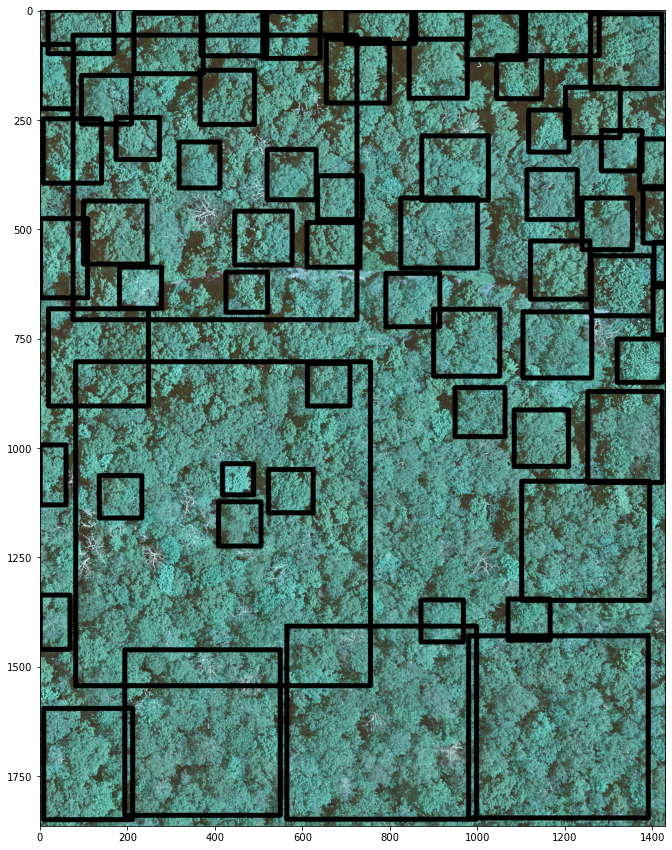

In [19]:
image3 = image.values.copy()

for index, row in pred_boxes.iterrows():
    cv2.rectangle(image3, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
cv2_imshow(image3)
plt.show()

## Comparison full image prediction and reference labels
Let's compare the labels and predictions over the tested image

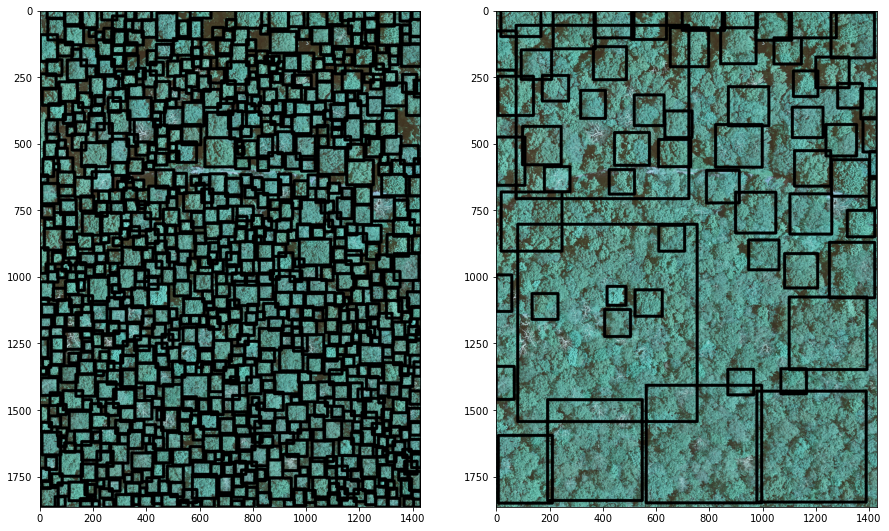

In [21]:
plt.figure(figsize=(15,15))
ax = plt.subplot(1, 2, 1), cv2_imshow(image2)
ax2 = plt.subplot(1, 2, 2), cv2_imshow(image3)
plt.show() # To show figure

**Interpretation:**
*   It seems the pretrained model doesn't perform well with the tested image
*   The low performance might be explained due to the pretrained model used 10cm images

## Tile-based prediction
To optimise the predictions, the DeepForest can be run [tile-wise](https://deepforest.readthedocs.io/en/latest/better.html)

The following cells show how to define the optimal window i.e. tile size

In [22]:
from deepforest import preprocess

#Create windows of 400px
windows = preprocess.compute_windows(image.values, patch_size=400,patch_overlap=0)
print(f'We have {len(windows)} in the image')

We have 20 in the image


/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/deepforest/predict.py:32: UserWarning: Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn("Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")


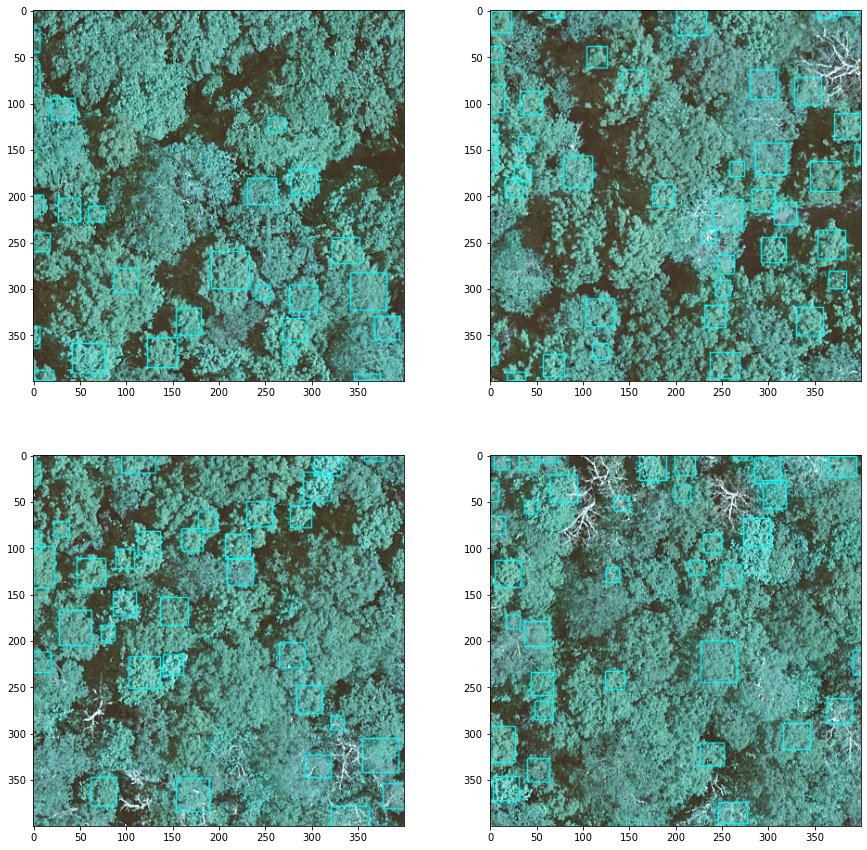

In [23]:
#Loop through a few sample windows, crop and predict
fig, axes, = plt.subplots(nrows=2,ncols=2, figsize=(15,15))
axes = axes.flatten()
for index2 in range(4):
    crop = image.values[windows[index2].indices()]
    #predict in bgr channel order, color predictions in red.
    boxes = model.predict_image(image=crop[...,::-1], return_plot = True)

    #but plot in rgb channel order
    axes[index2].imshow(boxes[...,::-1])

Once a suitable tile size is defined, we can run in a batch using the `predict_tile` function:

  0%|          | 0/20 [00:00<?, ?it/s]/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/deepforest/predict.py:32: UserWarning: Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')
  warnings.warn("Image type is {}, transforming to float32. This assumes that the range of pixel values is 0-255, as opposed to 0-1.To suppress this warning, transform image (image.astype('float32')")
100%|██████████| 20/20 [00:35<00:00,  1.78s/it]


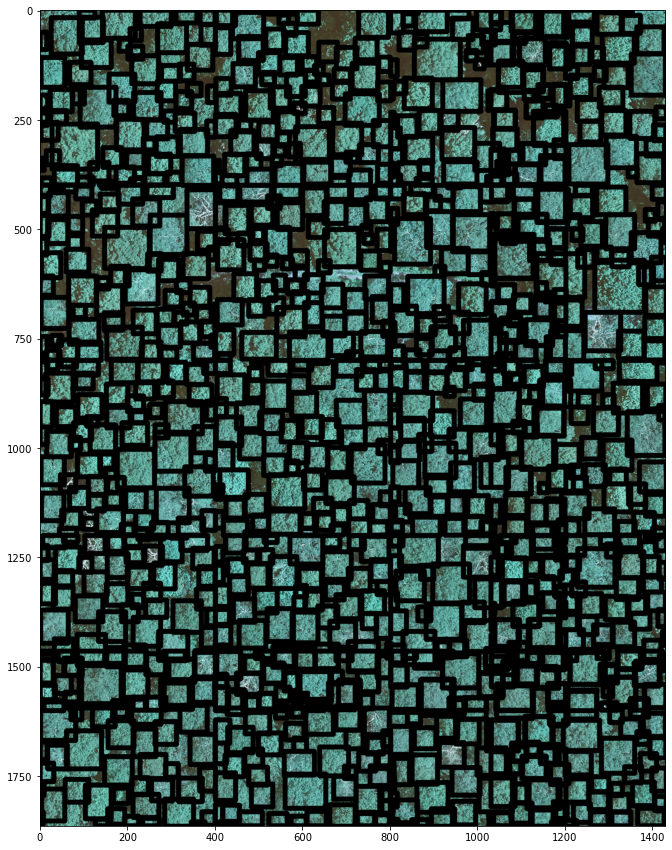

In [24]:
tile = model.predict_tile(image=image.values,return_plot=False,patch_overlap=0,iou_threshold=0.05,patch_size=400)

# plot predicted bbox
image_tile = image.values.copy()

for index, row in tile.iterrows():
    cv2.rectangle(image_tile, (int(row["xmin"]), int(row["ymin"])), (int(row["xmax"]), int(row["ymax"])), (0, 0, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize=(15,15))
cv2_imshow(image_tile)
plt.show()

**Interpretation**
* The tile-based prediction provides more reasonable results than predicting over the whole image

## [WIP] Batch Prediction with PyTorch
Source: https://github.com/dask/dask-examples/blob/main/machine-learning/torch-prediction.ipynb

In [133]:
# Investigate the tensor shape in the default predict image function in deepforest
from deepforest import main
m = main.deepforest()

def predict_image2(model, image, return_plot, device, iou_threshold=0.1):
    if image.dtype !="float32":
        image = image.astype("float32")
    image = preprocess.preprocess_image(image, device=device)
    print(image.shape)
    return None

crop = image.values[windows[0].indices()]
boxes = predict_image2(model=model,image=crop[...,::-1], return_plot = True, device=m.device)

Reading config file: /Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/deepforest/data/deepforest_config.yml
torch.Size([1, 3, 400, 400])


In [34]:
import pickle
import dask
import toolz
import torch

from dask.distributed import Client
client = Client()
client

/Users/acoca/anaconda3/envs/envai-book/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54628 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:54629' processes=4 threads=8, memory=16.00 GiB>

In [35]:
dask.utils.format_bytes(len(pickle.dumps(model)))

'123.15 MiB'

In [36]:
dmodel = dask.delayed(model.cpu()) # ensuring model is on the CPU

In [159]:
@dask.delayed
def load(index2):
    crop = image.values[windows[index2].indices()]
    return crop

@dask.delayed
def transform(img):
    if img.dtype !="float32":
        img = img.astype("float32")
    img = torch.tensor(img).permute(2, 0, 1)
    img = img / 255
    return img

@dask.delayed
def predict(batch, model):
    with torch.no_grad():
        out = model(batch)
    return out

In [115]:
@dask.delayed
def predict(batch, model):
    with tosrch.no_grad():
        out = model(batch)
    return out

@dask.delayed
def predict(batch, model):
    return batch.shape


In [160]:
objs = [load(x) for x in range(0,8)]

tensors = [transform(x) for x in objs]

batches = [dask.delayed(torch.stack)(batch)
           for batch in toolz.partition_all(1, tensors)]

predictions = [predict(batch, dmodel) for batch in batches]

In [161]:
predictions = dask.compute(*predictions)

distributed.worker - WARNING - Compute Failed
Function:  predict
args:      (tensor([[[[0.2196, 0.4784, 0.3961,  ..., 0.2902, 0.2431, 0.4157],
          [0.3647, 0.5647, 0.5333,  ..., 0.2941, 0.2706, 0.3294],
          [0.3922, 0.5765, 0.5804,  ..., 0.2902, 0.3333, 0.4667],
          ...,
          [0.6941, 0.6549, 0.6588,  ..., 0.7412, 0.7765, 0.4157],
          [0.6314, 0.5333, 0.5608,  ..., 0.7529, 0.7255, 0.2314],
          [0.6431, 0.5490, 0.5490,  ..., 0.5176, 0.8627, 0.4902]],

         [[0.3098, 0.4980, 0.2980,  ..., 0.3412, 0.2902, 0.4431],
          [0.3608, 0.6196, 0.5882,  ..., 0.3412, 0.3451, 0.3216],
          [0.3412, 0.6353, 0.7333,  ..., 0.3373, 0.3804, 0.4784],
          ...,
          [0.7725, 0.7373, 0.7490,  ..., 0.7098, 0.8392, 0.4392],
          [0.6941, 0.5961, 0.6392,  ..., 0.7804, 0.7647, 0.2000],
          [0.7216, 0.6235, 0.6275,  ..., 0.5804, 0.8706, 0.4392]],

         [[0.1373, 0.2824, 0.2392,  ..., 0.2353, 0.2039, 0.2745],
          [0.2118, 0.3529, 0.32

NotImplementedError: 

In [158]:
predictions

(torch.Size([1, 3, 400, 400]),
 torch.Size([1, 3, 400, 400]),
 torch.Size([1, 3, 400, 400]),
 torch.Size([1, 3, 400, 400]),
 torch.Size([1, 3, 400, 400]),
 torch.Size([1, 3, 400, 400]),
 torch.Size([1, 3, 400, 400]),
 torch.Size([1, 3, 400, 400]))

In [ ]:
client.close()